# Modeling System Resource Usage for Predictive Scheduling

## Data Science Consulting Project with [Manifold.co](manifold.co)

### Using time series, machine learning, and a  built-in algorithm (DeepAR) from AWS Sagemaker
DeepAR is a supervised recurrent neural network (RNN) used to forecast time series.

**Helpful Links**
- Sagemaker DeepAR documentation & FAQ [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)
- Example notebook with simulated data [here](https://github.com/JessieRayeBauer/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb)
- Instructions on how to set up an AWS notebook instance and role [here](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-set-up.html)
- Instructions on how to connect to AWS notebook without logging in (i.e., from local computer) [here](https://towardsdatascience.com/setting-up-and-using-jupyter-notebooks-on-aws-61a9648db6c5)

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
bucket = 'sagemaker-testtimeseries'
prefix = 'sagemaker/test-moredat'
 
# Define IAM role
import sagemaker

import sagemaker.predictor
from sagemaker.predictor import csv_serializer, json_deserializer
import boto3
import  s3fs
import re
from sagemaker import get_execution_role
import json
import math
from os import path
import sagemaker.amazon.common as smac

role = get_execution_role()


In [2]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

## Configure the container image to be used for the region that we are running in.
See this [list](https://docs.aws.amazon.com/general/latest/gr/rande.html#machinelearning_region) for possible regions

In [3]:
containers  = {
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]

Now we'll import the Python libraries we'll need.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import os
import time
import json
import glob

---
## Data

Let's download the data.  More information about this dataset can be found [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [5]:
#!wget http://gwa.ewi.tudelft.nl/fileadmin/pds/trace-archives/grid-workloads-archive/datasets/gwa-t-12/rnd.zip

In [6]:
#import zipfile
#with zipfile.ZipFile("rnd.zip","r") as zip_ref:
#    zip_ref.extractall("targetdir")

In [7]:
files = glob.glob(os.path.join('targetdir/rnd/2013-7', "*.csv"))
files_first200 = files[:300]
dfs = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in files_first200]
df = pd.concat(dfs, ignore_index=True)

files2 = glob.glob(os.path.join('targetdir/rnd/2013-8', "*.csv"))
files2_first200 = files2[:300]
dfs2 = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in files2_first200]
df2 = pd.concat(dfs2, ignore_index=True)

files3 = glob.glob(os.path.join('targetdir/rnd/2013-9', "*.csv"))
files3_first200 = files3[:300]
dfs3 = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in files3_first200]
df3 = pd.concat(dfs3, ignore_index=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifyin

In [8]:
newdat = df.append(df2)
newerdat = newdat.append(df3)
concatenated_df = newerdat

And take a look at it.

In [9]:
concatenated_df.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
0,1372629804,2,4799.999458,1412.799840,29.433333,16777216.0,1711274.4,0.266667,44.866667,14.333333,6.466667,413
1,1372630104,2,4799.999458,1454.399836,30.300000,16777216.0,1644165.6,0.066667,42.800000,14.866667,7.200000,413
2,1372630404,2,4799.999458,1444.799837,30.100000,16777216.0,1700089.6,0.466667,86.333333,15.466667,7.466667,413
3,1372630704,2,4799.999458,1483.199833,30.900000,16777216.0,1610611.2,0.066667,106.200000,22.133333,9.000000,413
4,1372631004,2,4799.999458,1521.599828,31.700000,16777216.0,1688904.8,0.066667,50.400000,26.400000,11.800000,413


In [10]:
concatenated_df.tail()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
2564395,1380490730,1,2699.998511,21.599988,0.800000,126020.0,55572.000000,0.0,0.400000,0.0,0.0,435
2564396,1380491030,1,2699.998511,21.599988,0.800000,126020.0,49455.200000,0.0,0.333333,0.0,0.0,435
2564397,1380491330,1,2699.998511,26.999985,1.000000,126020.0,54348.000000,0.0,0.466667,0.0,0.0,435
2564398,1380491630,1,2699.998511,23.399987,0.866667,126020.0,48406.666667,0.0,0.266667,0.0,0.0,435
2564399,1380491930,1,2699.998511,21.599988,0.800000,126020.0,50853.333333,0.0,0.400000,0.0,0.0,435


## Data Wrangling

In [11]:
# Formatting
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
concatenated_df.describe()
concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek
concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)

# Feature engineering with the date
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)
concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]
concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]

In [12]:
concatenated_df["start"] = concatenated_df.index
concatenated_df['target'] = concatenated_df['CPU usage [MHZ]']

In [14]:
df2 = concatenated_df.groupby('VM').resample('1min', how={'target':np.mean})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1502: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


In [15]:
df3 = concatenated_df.groupby('VM').resample('1min', how={'CPU capacity provisioned [MHZ]':np.mean})
df3.reset_index(level=0, inplace=True)
df3 = df3.fillna(method='ffill')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1502: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


In [16]:
df2.reset_index(level=0, inplace=True)

In [17]:
df2 = df2.fillna(method='ffill')

## Format data into json 
Note: context_length = determines how much context of the time series the model should take into account when making the prediction (i.e. how many previous points to look at). 
In addition to the context_length the model also takes into account the values of the time series at typical seasonal windows. So for minute data, the model will also look at the value of the series 60min ago, one day ago, one week ago, etc. 


In [19]:
freq = "1min"
context_length = 30
prediction_length = 30

In [20]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

This function converts our pandas df into a list of time series

In [21]:
time_series_test=[]
vm_index_range = df2['VM'].unique()
for i in vm_index_range:
    newseries = df2[df2['VM'] == i]['target']
    del newseries.index.name
    newseries.index = pd.to_datetime(newseries.index)
    time_series_test.append(newseries)

Here we will predict 30 data points, therefore we take out the trailing 30 points from each time series to define the training set. The test set contains the full range of each time series.

In [22]:
time_series_training=[]
vm_index_range = df2['VM'].unique()
for i in vm_index_range:
    newseries = df2[df2['VM'] == i]['target']
    del newseries.index.name
    newseries.index = pd.to_datetime(newseries.index)
    time_series_training.append(newseries[:-prediction_length])

## Push the JSON  files to S3 bucket

### NOTE: I had to upload two separate sets of training and testing JSON files to S3 because of limit restrictions. DeepAR can process multiple training files as long as they are in the same folder.

### You don't need to provide a test_data.json file, but it works better if you do. 

### Train_data.json files should have shuffled time series order. 

In [23]:
s3filesystem = s3fs.S3FileSystem()

This function converts the test and  train data into JSON lines for Sagemaker

In [67]:
encoding = "utf-8"

with s3filesystem.open(s3_data_path + "/test/test_data.json", 'wb') as fp:
    for ts in time_series_test:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding)) 

In [79]:
with s3filesystem.open(s3_data_path + "/train/train_data.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding)) 

## Set hyperparameters
### Sagemaker automatically adds lags (context_length), so context length can be shorter than seasons. We defined both context_length and prediction_length above (30 min)

In [24]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='test-demo-deepar',
    output_path="s3://" + s3_output_path
)

In [25]:
hyperparameters  = {
    "time_freq": freq,
    "context_length": context_length,
    "prediction_length": prediction_length,
    "num_cells": "32",
    "num_layers": "2",
    "likelihood": "student-t",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

The next line tells SageMaker to start an EC2 instance, download the data from S3, start training the model and save the trained model.

In [26]:
estimator.set_hyperparameters(**hyperparameters)

## Train model

In [27]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: test-demo-deepar-2018-06-28-13-58-20-940


....................
Arguments: train
[06/28/2018 14:01:33 INFO 140604405016384] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'dropout_rate': u'0.10', u'cardinality': u'', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'mini_batch_size': u'32', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[06/28/2018 14:01:33 INFO 140604405016384] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.001', u'num_cells': u'32', u'prediction_length': u'30', u'epochs': u'20', u'time_freq': u'1min', u'context_length': u'30', u'num_layers': u'2', u'mini_batch_size': u'32', u'likelihood': u'student-t', u'early_stopping_patience': u'

[06/28/2018 14:02:06 INFO 140604405016384] Epoch[3] Batch[5] avg_epoch_loss=4.288709
[06/28/2018 14:02:06 INFO 140604405016384] Epoch[3] Batch [5]#011Speed: 77.92 samples/sec#011loss=4.288709
[06/28/2018 14:02:08 INFO 140604405016384] Epoch[3] Batch[10] avg_epoch_loss=4.415494
[06/28/2018 14:02:08 INFO 140604405016384] Epoch[3] Batch [10]#011Speed: 81.34 samples/sec#011loss=4.567635
[06/28/2018 14:02:10 INFO 140604405016384] Epoch[3] Batch[15] avg_epoch_loss=4.448754
[06/28/2018 14:02:10 INFO 140604405016384] Epoch[3] Batch [15]#011Speed: 83.05 samples/sec#011loss=4.521927
[06/28/2018 14:02:10 INFO 140604405016384] processed a total of 492 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6465.120077133179, "sum": 6465.120077133179, "min": 6465.120077133179}}, "EndTime": 1530194530.761847, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1530194524.277529}

[06/28/2018 14:02:10 INFO 140604405016384] #throughput_metric: h

[06/28/2018 14:02:38 INFO 140604405016384] Epoch[8] Batch[5] avg_epoch_loss=4.057393
[06/28/2018 14:02:38 INFO 140604405016384] Epoch[8] Batch [5]#011Speed: 82.02 samples/sec#011loss=4.057393
[06/28/2018 14:02:40 INFO 140604405016384] Epoch[8] Batch[10] avg_epoch_loss=4.352681
[06/28/2018 14:02:40 INFO 140604405016384] Epoch[8] Batch [10]#011Speed: 87.76 samples/sec#011loss=4.707027
[06/28/2018 14:02:42 INFO 140604405016384] Epoch[8] Batch[15] avg_epoch_loss=4.344347
[06/28/2018 14:02:42 INFO 140604405016384] Epoch[8] Batch [15]#011Speed: 79.76 samples/sec#011loss=4.326012
[06/28/2018 14:02:42 INFO 140604405016384] processed a total of 512 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6243.2451248168945, "sum": 6243.2451248168945, "min": 6243.2451248168945}}, "EndTime": 1530194562.597116, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1530194556.339233}

[06/28/2018 14:02:42 INFO 140604405016384] #throughput_metric

[06/28/2018 14:03:20 INFO 140604405016384] Epoch[14] Batch[15] avg_epoch_loss=4.269593
[06/28/2018 14:03:20 INFO 140604405016384] Epoch[14] Batch [15]#011Speed: 84.77 samples/sec#011loss=4.188451
[06/28/2018 14:03:20 INFO 140604405016384] processed a total of 529 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6404.278993606567, "sum": 6404.278993606567, "min": 6404.278993606567}}, "EndTime": 1530194600.918233, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1530194594.50008}

[06/28/2018 14:03:20 INFO 140604405016384] #throughput_metric: host=algo-1, train throughput=82.5996059706 records/second
[06/28/2018 14:03:20 INFO 140604405016384] #progress_metric: host=algo-1, completed 75 % of epochs
[06/28/2018 14:03:20 INFO 140604405016384] loss did not improve for 1 epochs
[06/28/2018 14:03:21 INFO 140604405016384] Epoch[15] Batch[0] avg_epoch_loss=3.943161
[06/28/2018 14:03:23 INFO 140604405016384] Epoch[15] Batch[5] avg

[06/28/2018 14:04:08 INFO 140604405016384] Number of test batches scored: 10
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 21975.98385810852, "sum": 21975.98385810852, "min": 21975.98385810852}}, "EndTime": 1530194656.606306, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1530194634.630401}

[06/28/2018 14:04:16 INFO 140604405016384] #test_score (algo-1, wQuantileLoss[0.7]): 0.131677
[06/28/2018 14:04:16 INFO 140604405016384] #test_score (algo-1, wQuantileLoss[0.6]): 0.135584
[06/28/2018 14:04:16 INFO 140604405016384] #test_score (algo-1, mean_wQuantileLoss): 0.115275
[06/28/2018 14:04:16 INFO 140604405016384] #test_score (algo-1, wQuantileLoss[0.1]): 0.0698985
[06/28/2018 14:04:16 INFO 140604405016384] #test_score (algo-1, RMSE): 156.399565916
[06/28/2018 14:04:16 INFO 140604405016384] #test_score (algo-1, wQuantileLoss[0.3]): 0.115014
[06/28/2018 14:04:16 INFO 140604405016384] #test_score (algo-1, wQuantileLoss[0.9])

## Create endpoint and predictor
Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

Note: remember to delete the enpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [28]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: test-demo-deepar-2018-06-28-13-58-20-940
INFO:sagemaker:Creating endpoint-config with name test-demo-deepar-2018-06-28-13-58-20-940
INFO:sagemaker:Creating endpoint with name test-demo-deepar-2018-06-28-13-58-20-940


---------------------------------------------------------------!

In [29]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [30]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Hyperparameter tuning
Encountered some issues. First, unable to connect to data on S3 bucket and then I needed to request a limit increase from AWS. Code I tried is located [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html) for reference. 

*Update* Found possibly more helpful Python SDK Code [here](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker.html#SageMaker.Client.create_training_job). They also have Go listed.

## Visualize Model Predictions- Plot Individual Time Series and Predictions

In [31]:
new_time_series_training = []
for ts in time_series_training:
    new_time_series_training.append(ts.asfreq('T'))

In [32]:
new_time_series_test = []
for ts in time_series_test:
    new_time_series_test.append(ts.asfreq('T'))

### Plot VM 101

In [94]:
list_of_df  = predictor.predict(new_time_series_training[1:2]) # predicted forecast
actual_data = new_time_series_test[1:2] # full data set

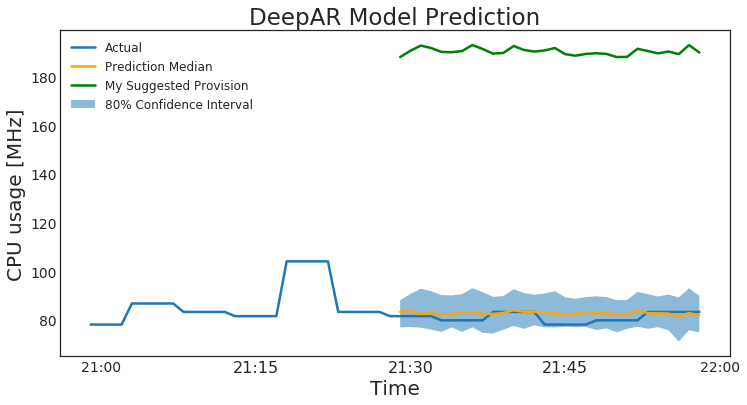

In [95]:
for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("DeepAR Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    #plt.yticks([10,20.40,50])
    plt.xlabel("Time", fontsize = 20)
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'g',linewidth = 2.5) # set requests for capacity allocation 
    plt.yticks(fontsize=14);
    #plt.axhline(y=5851.99912, color='r', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12,loc = 'best')
    #plt.savefig('VM101-withactual')
    plt.show()

### Plot VM 1

In [97]:
list_of_df  = predictor.predict(new_time_series_training[:1]) # predicted forecast
actual_data = new_time_series_test[:1] # full data set

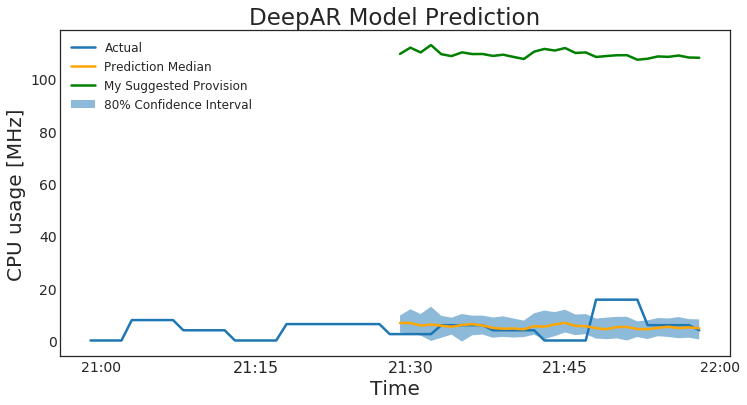

In [98]:
for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'g',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("DeepAR Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    #plt.yticks([50,100,150])
    plt.xlabel("Time", fontsize = 20)
    plt.yticks(fontsize=14);
   # plt.axhline(y=5199.99862, color='r', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12)
    plt.savefig('VM1')
    plt.show()

### Plot VM 103

In [100]:
list_of_df  = predictor.predict(new_time_series_training[2:3]) # predicted forecast
actual_data = new_time_series_test[2:3] # full data set

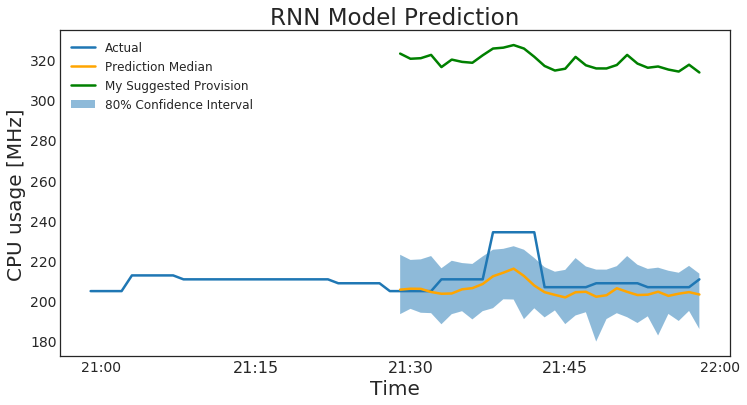

In [101]:
for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'g',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("RNN Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
   # plt.yticks([150,250,350])
    plt.xlabel("Time", fontsize = 20)
    plt.yticks(fontsize=14);
    #plt.axhline(y=2599.999299, color='r', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12)
    plt.savefig('VM103')
    plt.show()

### Plot VM 106

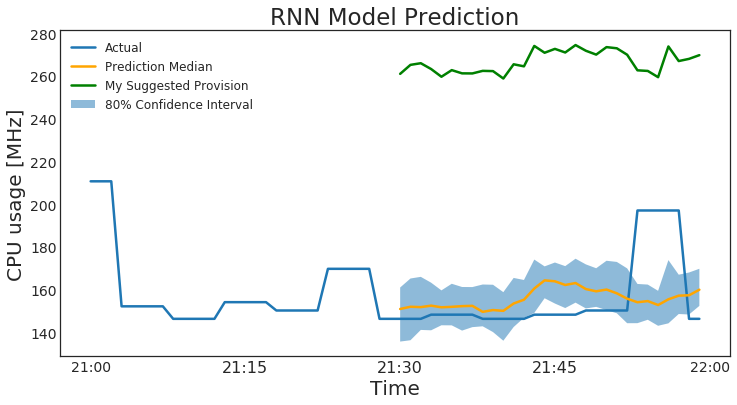

In [103]:
list_of_df  = predictor.predict(new_time_series_training[3:4]) # predicted forecast
actual_data = new_time_series_test[3:4] # full data set

for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'g',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("RNN Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
   # plt.yticks([150,250,350])
    plt.xlabel("Time", fontsize = 20)
    #plt.axhline(y=1.170400e+04, color='r', linestyle='-', label = 'Actual Provision')
    plt.yticks(fontsize=14);
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12)
    #plt.savefig('VM106-w-actual')
    plt.show()

### Plot VM 9

In [105]:
list_of_df  = predictor.predict(new_time_series_training[295:296]) # predicted forecast
actual_data = new_time_series_test[295:296] # full data set

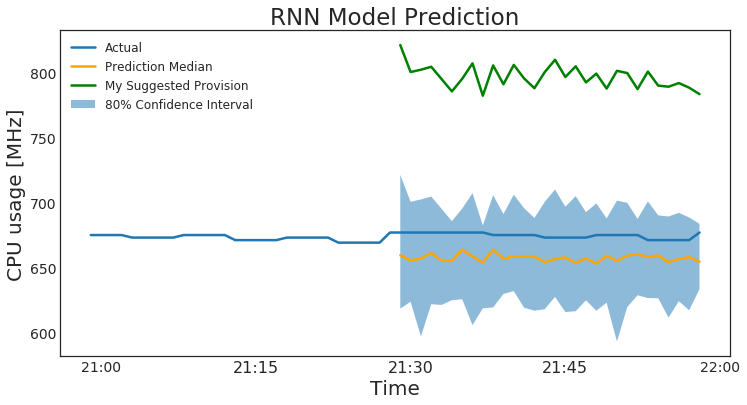

In [106]:
for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'g',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("RNN Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    #plt.yticks([150,250,350])
    plt.xlabel("Time", fontsize = 20)
    plt.yticks(fontsize=14);
    #plt.axhline(y=2925.999338, color='r', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12)
    plt.savefig('VM9')
    plt.show()

# DOES MY MODEL UNDER PROVISION? No!

## Used VM 237, where original usage was highest at the end of time series (where we are predicting) at 56%.

In [108]:
list_of_df  = predictor.predict(new_time_series_training[90:91]) # predicted forecast
actual_data = new_time_series_test[90:91] # full data set

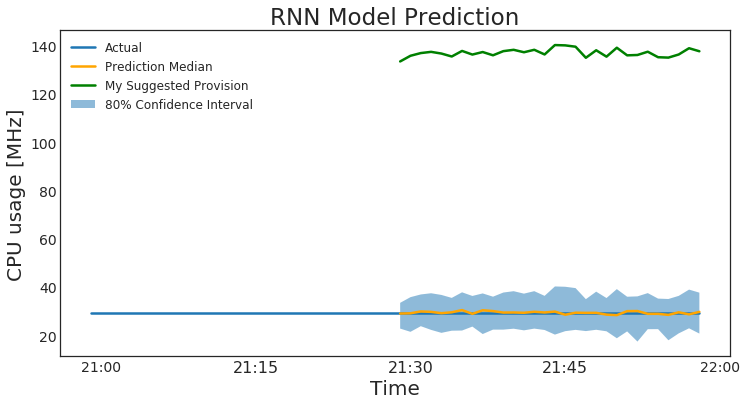

In [109]:
for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'g',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("RNN Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    #plt.yticks([150,250,350])
    plt.xlabel("Time", fontsize = 20)
    plt.yticks(fontsize=14);
    #plt.axhline(y=5852.000058, color='r', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12)
   # plt.savefig('VM237-w-actual')
    plt.show()

## Delete endpoint when finished (leave open for real-time)

In [116]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: test-demo-deepar-2018-06-25-15-16-58-345
